In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [113]:
ticker = yf.Ticker("TLKM.JK")

try:
    # Attempt to fetch historical data
    data = ticker.history(start='2020-01-01', end='2024-12-31')
except Exception as e:
    print("An error occurred while fetching data:", e)

In [83]:
data.index.name = 'Date'  # tanggal harus di-index
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00+07:00,3137.597589,3161.307395,3082.274710,3090.177979,52094000
2020-01-03 00:00:00+07:00,3129.694196,3145.500732,3105.984392,3145.500732,70032900
2020-01-06 00:00:00+07:00,3105.984288,3137.597360,3105.984288,3129.694092,42908900
2020-01-07 00:00:00+07:00,3105.984671,3137.597746,3098.081402,3113.887939,51837600
2020-01-08 00:00:00+07:00,3098.081195,3121.791000,3082.274658,3082.274658,52402600


In [84]:
data.describe()

,Open,High,Low,Close,Volume
count,1211.000000,1211.000000,1211.000000,1211.000000,1.211000e+03
mean,3222.113387,3257.623162,3183.753537,3219.462431,1.169406e+08
std,513.047954,511.763844,512.681783,514.423175,7.770911e+07
min,2015.333518,2151.168708,1936.300600,2070.656250,0.000000e+00
25%,2800.000000,2840.539359,2758.741333,2799.010986,6.959575e+07
50%,3204.221198,3245.502650,3160.000000,3210.000000,9.720550e+07
75%,3666.005917,3707.868544,3637.918744,3666.005859,1.403551e+08
max,4250.483398,4313.788335,4205.265490,4295.701172,1.155861e+09


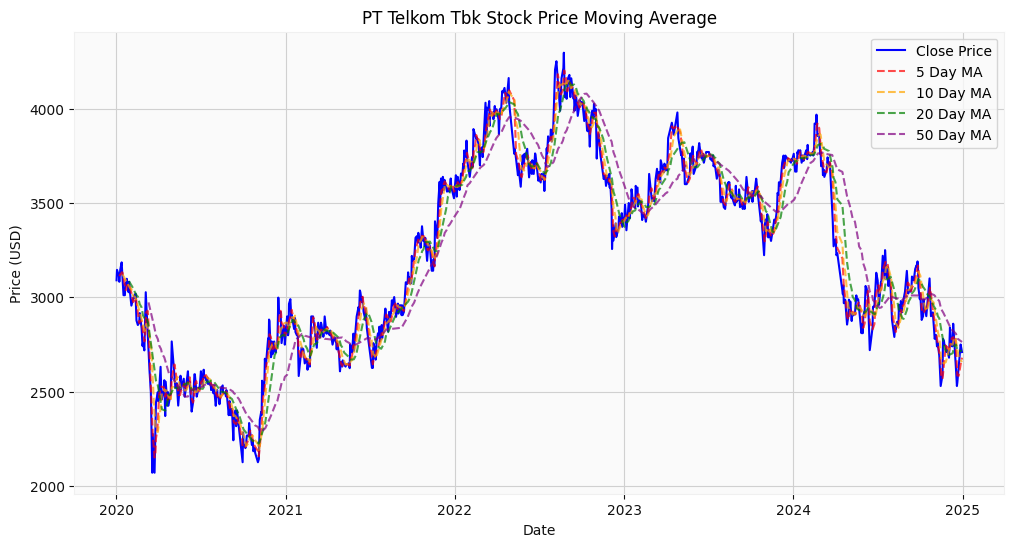

In [85]:
# Calculate the 20-day moving average of Apple's closing price
moving_average_5 =data['Close'].rolling(window=5).mean()
moving_average_10 =data['Close'].rolling(window=10).mean()
moving_average_20 =data['Close'].rolling(window=20).mean()
moving_average_50 =data['Close'].rolling(window=50).mean()

# Add the moving average as a new column in the DataFrame
data['MA_5'] = moving_average_5
data['MA_10'] = moving_average_10
data['MA_20'] = moving_average_20
data['MA_50'] = moving_average_50

# Plot the closing prices and the 20-day moving average
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue', alpha=1.0)
plt.plot(data.index, data['MA_5'], label='5 Day MA', linestyle='--', color='red', alpha=0.7)
plt.plot(data.index, data['MA_10'], label='10 Day MA', linestyle='--', color='orange', alpha=0.7)
plt.plot(data.index, data['MA_20'], label='20 Day MA', linestyle='--', color='green', alpha=0.7)
plt.plot(data.index, data['MA_50'], label='50 Day MA', linestyle='--', color='purple', alpha=0.7)
plt.title('PT Telkom Tbk Stock Price Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

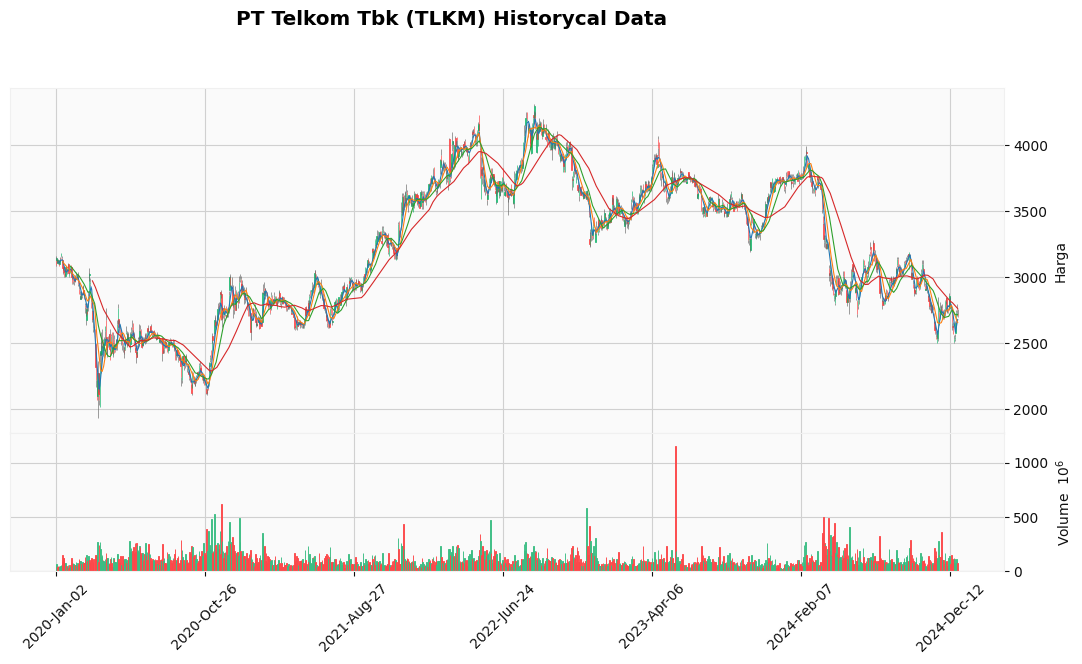

In [86]:
import mplfinance as mpf

# Plot candlestick
mpf.plot(
    data,
    type='candle',
    style='yahoo',
    title='PT Telkom Tbk (TLKM) Historycal Data',
    ylabel='Harga',
    volume=True,
    show_nontrading=False, # not shown non-trading days
    mav=(5, 10, 20, 50),  # moving averages
    figratio=(16, 8),
    figscale=1.2
)


In [90]:
# RSI (14 hari)
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# MACD
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

data['Predict'] = data['Close'].shift(-20)
data = data.dropna()

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'RSI_14', 'MACD', 'MACD_Signal']

X = data[features]
y = data['Predict']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 38805.73780017675
Mean Absolute Error: 154.07603154502215
R2 Score: 0.8553417458981016


In [93]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Daftar model dan parameternya
models_params = {
    "Ridge": {
        "model": Ridge(),
        "params": {
            "model__alpha": [0.01, 0.1, 1, 10, 100]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "model__max_depth": [3, 5, 10, None],
            "model__min_samples_split": [2, 5],
            "model__min_samples_leaf": [1, 2]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "model__n_estimators": [50, 100],
            "model__max_depth": [5, 10, None],
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "model__kernel": ['linear', 'rbf'],
            "model__C": [1, 10],
            "model__epsilon": [0.1, 0.5]
        }
    }
}

results = {}

for name, mp in models_params.items():
    print(f"\n🔍 Tuning model: {name}")
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp['model'])
    ])
    
    grid = GridSearchCV(pipe, mp['params'], cv=5, scoring='r2')
    grid.fit(X_train, y_train)

    print("Best Params:", grid.best_params_)
    print("Best R2 Score:", grid.best_score_)
    results[name] = {
        "best_params": grid.best_params_,
        "best_score": grid.best_score_
    }

# Optional: Print semua hasil
print("\n📊 Summary Hasil GridSearch:")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Params: {result['best_params']}")
    print(f"  R2: {result['best_score']:.4f}")


🔍 Tuning model: Ridge
Best Params: {'model__alpha': 0.1}
Best R2 Score: 0.8309835211318137

🔍 Tuning model: DecisionTree
Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best R2 Score: 0.9245302430310721

🔍 Tuning model: RandomForest
Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
Best R2 Score: 0.9524937553607067

🔍 Tuning model: SVR
Best Params: {'model__C': 1, 'model__epsilon': 0.5, 'model__kernel': 'linear'}
Best R2 Score: 0.8254489181830573

📊 Summary Hasil GridSearch:
Ridge:
  Params: {'model__alpha': 0.1}
  R2: 0.8310
DecisionTree:
  Params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
  R2: 0.9245
RandomForest:
  Params: {'model__max_depth': None, 'model__n_estimators': 100}
  R2: 0.9525
SVR:
  Params: {'model__C': 1, 'model__epsilon': 0.5, 'model__kernel': 'linear'}
  R2: 0.8254


In [94]:
# Buat pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42))
])

# Latih model
rf_pipeline.fit(X_train, y_train)

# Prediksi
y_pred = rf_pipeline.predict(X_test)

# Evaluasi
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Tampilkan hasil
print(f"R2 Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")
print(f"MSE      : {mse:.4f}")

R2 Score : 0.9665
MAE      : 64.3143
MSE      : 8985.6302


In [ ]:
predictions = rf_pipeline.predict(X_test)



In [106]:
import pandas as pd

def predict_next_20_days(df, rf_pipeline, scaler=None):
    # Pastikan semua fitur tersedia
    required_features = ['Open', 'High', 'Low', 'Close', 'Volume', 
                         'MA_5', 'MA_10', 'MA_20', 'MA_50', 
                         'RSI_14', 'MACD', 'MACD_Signal']
    
    for col in required_features:
        if col not in df.columns:
            raise ValueError(f"Kolom fitur '{col}' tidak ditemukan dalam DataFrame")

    # Ambil baris terakhir sebagai input awal
    last_known_data = df[required_features].iloc[[-1]].copy()
    preds = []
    current_data = last_known_data.copy()

    for _ in range(20):
        X_input = current_data[required_features].iloc[[-1]]

        # Scaling jika ada
        if scaler:
            X_input_scaled = scaler.transform(X_input)
        else:
            X_input_scaled = X_input

        # Prediksi harga Close
        y_pred = rf_pipeline.predict(X_input_scaled)[0]
        preds.append(y_pred)

        # Buat baris baru dengan prediksi sebagai Close
        new_row = current_data.iloc[-1].copy()
        new_row['Close'] = y_pred

        # Update indikator moving average
        price_series = current_data['Close'].tolist() + [y_pred]
        new_row['MA_5'] = pd.Series(price_series[-5:]).mean() if len(price_series) >= 5 else y_pred
        new_row['MA_10'] = pd.Series(price_series[-10:]).mean() if len(price_series) >= 10 else y_pred
        new_row['MA_20'] = pd.Series(price_series[-20:]).mean() if len(price_series) >= 20 else y_pred
        new_row['MA_50'] = pd.Series(price_series[-50:]).mean() if len(price_series) >= 50 else y_pred

        # Update indikator dummy RSI dan MACD
        new_row['RSI_14'] = 50  # Placeholder
        new_row['MACD'] = 0     # Placeholder
        new_row['MACD_Signal'] = 0  # Placeholder

        # Gunakan data prediksi sebagai baris baru
        current_data = pd.concat([current_data, new_row.to_frame().T], ignore_index=True)

    return preds

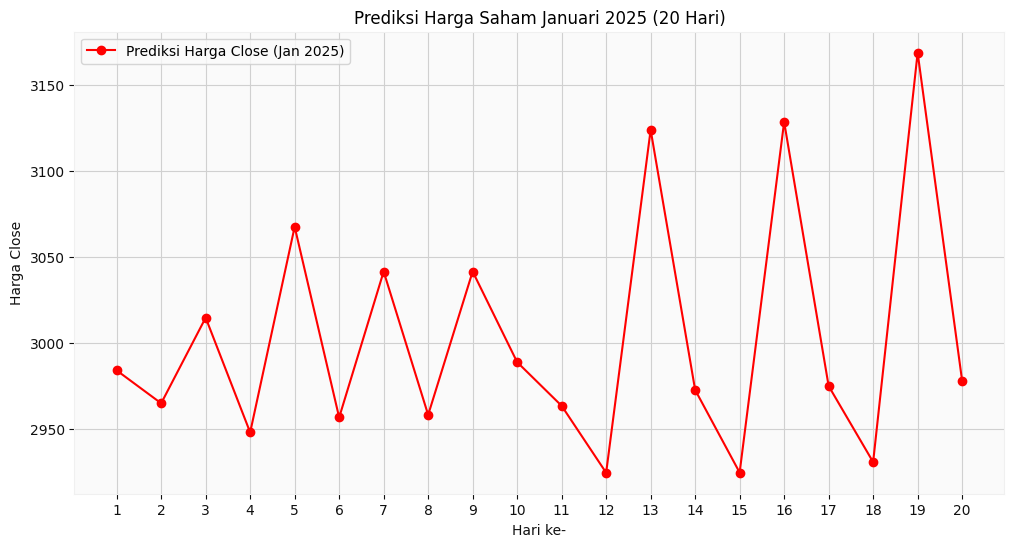

In [ ]:
import matplotlib.pyplot as plt

# Jalankan prediksi 20 hari ke depan (otomatis pakai data terakhir dari df)
preds = predict_next_20_days(data, rf_pipeline)


# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), preds, marker='o', label='Prediksi Harga Close (Jan 2025)', color='red')
plt.title('Prediksi Harga Saham Januari 2025 (20 Hari)')
plt.xlabel('Hari ke-')
plt.ylabel('Harga Close')
plt.xticks(range(1, 21))
plt.grid(True)
plt.legend()
plt.show()

In [125]:
import yfinance as yf

# Ambil data saham AAPL untuk Januari 2025
ticker = 'TLKM.JK'  # Ganti sesuai saham yang kamu pakai
data_real = yf.download(ticker, start='2025-01-01', end='2025-02-01')

# Reset index agar kolom Date bisa diakses
data_real.reset_index(inplace=True)

# Ambil hanya kolom tanggal dan Close price
real_jan_close = data_real[['Date', 'Close']]

[*********************100%***********************]  1 of 1 completed


In [126]:
import pandas as pd

# Buat tanggal dummy dari 1 sampai 20 Januari 2025 (hari kerja, weekday only)
from pandas.tseries.offsets import BDay

# Dapatkan 20 hari kerja di Januari 2025
start_date = pd.to_datetime('2025-01-01')
pred_dates = pd.date_range(start=start_date, periods=20, freq=BDay())

# Buat DataFrame prediksi
pred_df = pd.DataFrame({'Date': pred_dates, 'Predicted_Close': preds})

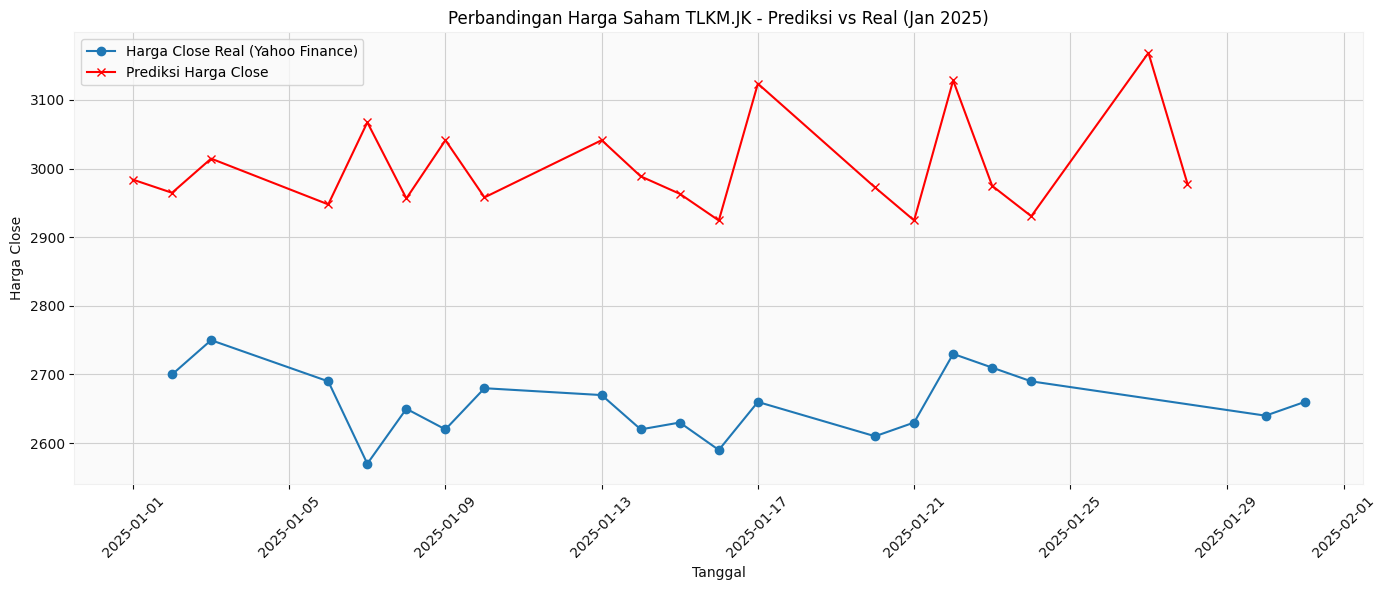

In [127]:
plt.figure(figsize=(14, 6))

# Plot harga real
plt.plot(real_jan_close['Date'], real_jan_close['Close'], label='Harga Close Real (Yahoo Finance)', marker='o')

# Plot harga prediksi
plt.plot(pred_df['Date'], pred_df['Predicted_Close'], label='Prediksi Harga Close', marker='x', color='red')

plt.title(f'Perbandingan Harga Saham {ticker} - Prediksi vs Real (Jan 2025)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()